# CARTPOLE

## Install Packages

In [1]:
# Updating the package list and installing necessary packages for the project
!apt-get update && apt-get install swig cmake
# Updating the package list and installing ffmpeg and freeglut3-dev for visualization, xvfb for virtual display
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb
# Installing the Box2D environment for physics simulation
!pip install box2d-py
# Installing the Stable Baselines3 library for reinforcement learning along with extra dependencies
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,105 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Ign:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
G

## Import Libraries and utility setup

In [2]:
# Importing required libraries and modules
import os
import gymnasium as gym  # Importing gym library as gymnasium

# Printing the version of gym library
print(f"{gym.__version__=}")
import base64
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import stable_baselines3

# Printing the version of stable_baselines3 library
print(f"{stable_baselines3.__version__=}")
from stable_baselines3 import DQN
from IPython import display as ipythondisplay
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

import torch as th
import torch.nn as nn
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env



# Setting up a fake display for video rendering
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


gym.__version__='0.29.1'


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


stable_baselines3.__version__='2.4.0a10'


## Mount Google Drive

In [3]:
# Mounting the Google Drive to access and store files
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


## Define a callback to store model on interval (for checkpointing)

In [4]:
# Defining a callback class to save the model at specified intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval  # Setting the interval of saving
        self.save_path = save_path  # Setting the path to save models

    def _on_step(self) -> bool:
        # Saving the model if the current timestep is a multiple of the save interval
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')  # Defining the file name for the model
            self.model.save(save_file)  # Saving the model
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')  # Printing a message on successful save
        return True


## Create directories for storage of model and logs

In [5]:
# Creating directories for storing logs and models
log_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/gym/"  # Directory for storing training logs
models_dir = "/content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/models/"  # Directory for storing models

# Ensuring the directories exist or creating them
os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)


## Initialise the Gym environment

In [4]:
# Creating and wrapping the environment with a monitor for logging
env = gym.make("CartPole-v1", render_mode="human")

env = Monitor(env, log_dir)  # Wrapping the environment with a monitor for logging


NameError: name 'log_dir' is not defined

## Utility Functions

### Record Video

In [20]:
# Function to record videos of the agent's performance
def record_video(env_id, model, video_length=500, prefix="", video_folder="/content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/videos/)"):
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode='rgb_array')])  # Creating a dummy environment for recording
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()  # Resetting the environment
    for _ in range(video_length):
        action, _ = model.predict(obs)  # Predicting actions using the model
        obs, _, _, _ = eval_env.step(action)  # Taking a step in the environment
    eval_env.close()  # Closing the evaluation environment

### Show Video

In [21]:
# Defining functions for video recording and displaying

# Function to display recorded videos
def show_videos(video_path="", prefix=""):
    html = []
    # Reading and encoding videos to display
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{0}" autoplay
                      loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
            </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))  # Displaying the videos




## Train the Agent

### Initialise the callback

In [9]:
# Instantiating and training the DQN agent with callback for saving
save_interval = 50000 // 3  # Setting save interval to save three models: at the beginning, middle, and end of training
callback = SaveOnIntervalCallback(save_interval, save_path=models_dir)  # Initializing the callback


# custon ann


# DQN Model Hyperparameters for CartPole-v1

The DQN model is configured with the following hyperparameters to optimize performance on the CartPole-v1 environment:

- **Policy**: `MlpPolicy`  
  - A Multi-Layer Perceptron (MLP) policy network, which is well-suited for handling the state input of the CartPole environment.

- **Learning Rate**: `2.3e-3`  
  - Determines the step size at each iteration while moving toward a minimum of the loss function. A moderate learning rate helps the model converge effectively.

- **Batch Size**: `64`  
  - Specifies the number of experiences sampled from the replay buffer for each training update. Larger batches help stabilize training.

- **Buffer Size**: `100000`  
  - The size of the replay buffer, which stores past experiences to sample from, allowing the model to learn from past actions and avoid overfitting.

- **Learning Starts**: `1000`  
  - The number of initial timesteps to take before learning begins. This delay ensures the buffer has a variety of experiences to draw from initially.

- **Discount Factor (Gamma)**: `0.99`  
  - Controls the importance of future rewards, with values closer to 1 focusing more on future gains, suitable for long-term strategy.

- **Target Update Interval**: `10`  
  - Frequency of updates to the target network, which stabilizes the Q-learning updates by slowing the target network's changing rate.

- **Train Frequency**: `256`  
  - Determines how often the model is trained, specified in timesteps. Higher frequencies allow more frequent learning updates.

- **Gradient Steps**: `128`  
  - The number of gradient descent steps performed during each update. This allows multiple training steps per data sample for improved learning.

- **Exploration Fraction**: `0.16`  
  - Fraction of the training period in which the exploration rate (ε) linearly decreases to promote exploration early in training.

- **Exploration Final Epsilon**: `0.04`  
  - The minimum exploration rate after decay, ensuring the agent maintains some degree of exploration throughout training.

- **Policy Architecture (net_arch)**: `[256, 256]`  
  - Specifies a two-layer neural network with 256 units in each layer for the policy network, providing a balance of complexity and performance.

- **Verbose**: `1`  
  - Enables detailed logging for monitoring model training progress.



In [ ]:
# Custom neural network with two hidden layers (256, 256)
class CustomNetwork(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super(CustomNetwork, self).__init__(observation_space, features_dim)
        input_dim = observation_space.shape[0]

        # Define network layers
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

    def forward(self, x):
        return self.network(x)


# Define the CartPole environment and wrap it for vectorization
env = make_vec_env("CartPole-v1", n_envs=1, vec_env_cls=DummyVecEnv)

# Set up the DQN model with the custom network
model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=2.3e-3,
    batch_size=64,
    buffer_size=100000,
    learning_starts=0,
    gamma=0.99,
    target_update_interval=10,
    train_freq=256,
    gradient_steps=128,
    exploration_fraction=0.16,
    exploration_final_eps=0.04,
    policy_kwargs=dict(features_extractor_class=CustomNetwork, net_arch=[]),  # Use custom network
    verbose=1
)

# Train the model
model.learn(total_timesteps=int(50000), log_interval=4)

# Save the model
model.save("dqn_cartpole_custom_network")

# Cleanup and reload the model
del model
model = DQN.load("dqn_cartpole_custom_network")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 19.8     |
|    ep_rew_mean      | 19.8     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 45       |
|    time_elapsed     | 1        |
|    total_timesteps  | 79       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.4     |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.979    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 46       |
|    time_elapsed     | 3        |
|    total_timesteps  | 171      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 20.5  

Looking at the training, we can see that the average length of the episodes increases over time. This is a sign that the agent is learning, as for how CartPole is stuctured, the most the episode lassts (up to a max of 500 steps when it stops automatically, the better is the performance and therefore the reward).
Now I save the model


In [ ]:
model.save(os.path.join(models_dir, "model_final"))  # Saving the final model

testing if the model gets loaded correclty

In [ ]:
emodel = DQN.load('/content/drive/MyDrive/43008 Reinforcement Learning/Week9/train2/models/model_final')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Record and Store Videos

In [7]:

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view(models_dir):
    identifiers = get_model_identifiers(models_dir)  # Getting model identifiers
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["end"], [final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')  # Forming the model path
        model = DQN.load(model_path)  # Loading the model
        record_video("CartPole-v1", model, video_length=5000, prefix=f'{stage}')  # Recording video

    # Displaying the videos
    for stage in ["beginning", "middle", "end"]:
        show_videos("videos", prefix=f'{stage}')  # Showing videos

### Call function to record and store videos

In [ ]:
view(models_dir)  # Calling the view function

Saving video to /content/drive/MyDrive/43008/Week9/train2/videos/dqn-lunar-end-step-0-to-step-5000.mp4
Moviepy - Building video /content/drive/MyDrive/43008/Week9/train2/videos/dqn-lunar-end-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008/Week9/train2/videos/dqn-lunar-end-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008/Week9/train2/videos/dqn-lunar-end-step-0-to-step-5000.mp4


I then tested the performances of te loaded agent using the metric of stablebaseline

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=True)
print(f"Mean reward over 10 episodes: {mean_reward} ± {std_reward}")

Mean reward over 10 episodes: 500.0 ± 0.0


perfect score every time. The agent learned very well

## Plot the learning curve

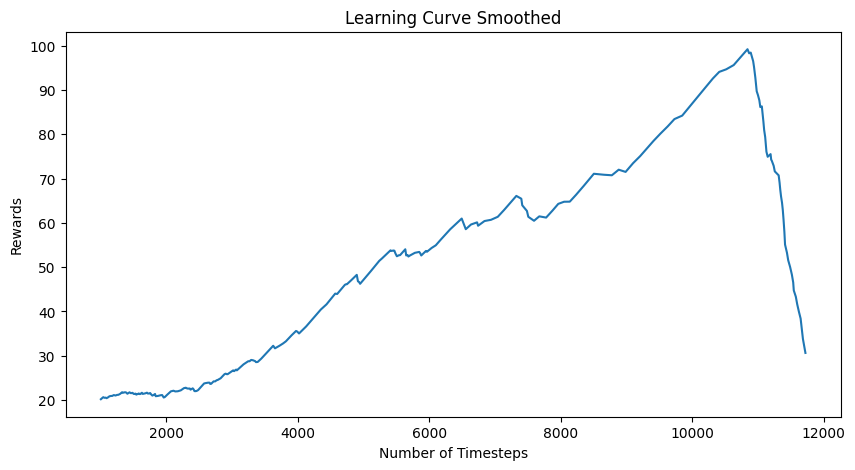

In [ ]:
# Function for plotting the learning curve of the agent
def plot_results(log_folder, title="Learning Curve"):
    x, y = ts2xy(load_results(log_folder), "timesteps")  # Loading the results
    y = np.convolve(y, np.ones((50,))/50, mode='valid')  # Smoothing the curve using a moving average of 50 episodes
    x = x[len(x) - len(y):]  # Adjusting the x-axis values
    plt.figure(figsize=(10,5))  # Setting figure size
    plt.plot(x, y)  # Plotting the learning curve
    plt.xlabel("Number of Timesteps")  # Labeling x-axis
    plt.ylabel("Rewards")  # Labeling y-axis
    plt.title(title + " Smoothed")  # Adding title to the plot
    plt.show()  # Displaying the plot

plot_results(log_dir)  # Calling the function to plot the learning curve


# PPO


# PPO Model Hyperparameters for CartPole-v1


## Arguments Used in the PPO Model

- **policy**: `"MlpPolicy"`  
  - Specifies the policy architecture. `MlpPolicy` indicates a multi-layer perceptron policy suitable for processing low-dimensional state inputs from the CartPole environment.

- **env**: `env`  
  - The environment instance, in this case, `CartPole-v1`, which provides the CartPole task's state and action spaces.

- **learning_rate**: `lambda f: f * 0.001`  
  - Defines a linear schedule for the learning rate, starting with `0.001`. The learning rate adjusts based on training progress to facilitate stable convergence.

- **batch_size**: `256`  
  - The number of transitions sampled from the rollout buffer for each optimization step. A higher batch size helps stabilize updates.

- **n_steps**: `32`  
  - The number of steps to run for each environment per update. The agent collects `32` steps of experience per environment before each update, balancing memory efficiency with learning frequency.

- **n_epochs**: `20`  
  - The number of times the PPO algorithm updates the policy with each batch of sampled experience. Higher values allow the agent to learn more thoroughly from each batch.

- **gamma**: `0.98`  
  - The discount factor that determines how much future rewards are discounted compared to immediate rewards. Setting this slightly below 1 (`0.98`) emphasizes immediate rewards slightly more while still considering future gains.

- **gae_lambda**: `0.8`  
  - The lambda parameter for Generalized Advantage Estimation (GAE), controlling the trade-off between bias and variance in advantage estimation. Lower values tend to reduce variance at the cost of introducing more bias.

- **clip_range**: `lambda f: f * 0.2`  
  - Defines a linear schedule for the clip range. PPO limits how far policy updates can go by clipping the ratio between new and old policies. The range starts at `0.2` and adjusts throughout training.

- **ent_coef**: `0.0`  
  - Entropy coefficient, which regularizes the policy by encouraging exploration. Set to `0.0` in this case, meaning no additional exploration bonus is applied.

- **policy_kwargs**: `policy_kwargs`  
  - Specifies additional arguments for the policy network, including the custom MLP architecture `CustomMLP` with hidden layers `[256, 256]`. This is defined using a custom class that allows for a flexible network structure.

- **verbose**: `1`  
  - Sets the verbosity level for logging. A setting of `1` provides basic training information and progress updates.

## Custom Network Architecture

The custom network is defined with two hidden layers, each with `256` units, using the `ReLU` activation function. This architecture is specified in `policy_kwargs` through the `features_extractor_class` argument. The custom architecture allows for enhanced control over the network's structure, which can be beneficial for specific tasks.

### CustomMLP Class

The custom architecture is created in the `CustomMLP` class. Key elements of this class include:
  - **Hidden Layers**: `[256, 256]` fully connected layers.
  - **Activation Function**: `ReLU`, providing non-linearity between layers.
  - **Sequential Model**: The layers are combined into a sequential model for ease of forward pass definition.

This network architecture is well-suited for the state-space dimensions of CartPole-v1 and provides a balance of complexity and computational efficiency.

## Model Training

The model is trained for `1e5` timesteps, with logs printed every 4 steps (`log_interval=4`), providing regular progress updates.




In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
import torch as th

class CustomMLP(BaseFeaturesExtractor):
    def __init__(self, observation_space, hidden_layers=[256, 256], activation=nn.ReLU):
        super(CustomMLP, self).__init__(observation_space, features_dim=hidden_layers[-1])
        layers = []
        input_dim = observation_space.shape[0]  # Get input dimension from observation space

        # Create the hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(activation())
            input_dim = hidden_dim

        # Define the sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define policy_kwargs with the custom architecture
policy_kwargs = dict(
    features_extractor_class=CustomMLP,
)

# Set up the PPO model with specified hyperparameters and custom network
model = PPO(
    policy="MlpPolicy",
    env=env,
    learning_rate=lambda f: f * 0.001,  # Linear schedule for learning rate
    batch_size=256,
    n_steps=32,
    n_epochs=20,
    gamma=0.98,
    gae_lambda=0.8,
    clip_range=lambda f: f * 0.2,  # Linear schedule for clip range
    ent_coef=0.0,
    policy_kwargs=policy_kwargs,
    verbose=1
)

# Train the model
model.learn(total_timesteps=int(1e5), log_interval=4)




Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.000802     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 153         |
|    ep_rew_mean          | 153         |
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 2176        |
|    time_elapsed         | 1588        |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.008896864 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.0608      |
|    entropy_loss         | -0.253      |
|    explained_variance   | -0.107      |
|    learning_rate        | 0.000304    |
|    loss                 | -0.0204     |
|    n_updates            | 43500       |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 0.000277    |
-----------------------

In [12]:
model.save("/content/drive/MyDrive/43008 Reinforcement Learning/Week9/train2/models/ppo_final") # Saving the final model

SyntaxError: unmatched ')' (<ipython-input-12-fde04613273e>, line 1)

In [30]:
#import PPO
from stable_baselines3 import PPO
ppomodel=PPO.load('/content/drive/MyDrive/cartpoletest/ppo_final/')


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [32]:
record_video("CartPole-v1", ppomodel, video_length=5000)  # Recording video

Saving video to /content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/videos/)/-step-0-to-step-5000.mp4
Moviepy - Building video /content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/videos/)/-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/videos/)/-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/43008 Reinforcement Learning/Cartpole/DQN/videos/)/-step-0-to-step-5000.mp4


again testing performance

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(ppomodel, env, n_eval_episodes=10, render=True)
print(f"Mean reward over 10 episodes: {mean_reward} ± {std_reward}")

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward over 10 episodes: 500.0 ± 0.0


perfect score as DQN. GREAT

#Comparing the algorithms

first I tested the imported models

In [45]:
# Load the trained models
ppo_model = PPO.load('/content/drive/MyDrive/cartpoletest/ppo_final/')
dqn_model = DQN.load('/content/drive/MyDrive/cartpoletest/model_final/')

# Define the CartPole environment
env = gym.make("CartPole-v1")

# Test environment reset
obs, info = env.reset()
print("Initial observation from env.reset():", obs)
print("Additional info from env.reset():", info)

# Test model prediction with PPO model
action, _ = ppo_model.predict(obs)
print("PPO Model prediction (action):", action)

# Test model prediction with DQN model
action, _ = dqn_model.predict(obs)
print("DQN Model prediction (action):", action)

# Test a random action for comparison
random_action = env.action_space.sample()
print("Random action:", random_action)

# Take a step in the environment with each action
obs, reward, done, truncated, info = env.step(action)
print("Observation after step:", obs)
print("Reward after step:", reward)
print("Done flag after step:", done)
print("Truncated flag after step:", truncated)
print("Info after step:", info)


Initial observation from env.reset(): [ 0.02505497  0.0324288  -0.04777396 -0.04744694]
Additional info from env.reset(): {}
PPO Model prediction (action): 1
DQN Model prediction (action): 0
Random action: 0
Observation after step: [ 0.02570354 -0.16197671 -0.0487229   0.22978841]
Reward after step: 1.0
Done flag after step: False
Truncated flag after step: False
Info after step: {}


They both worked fine so it was time to compare

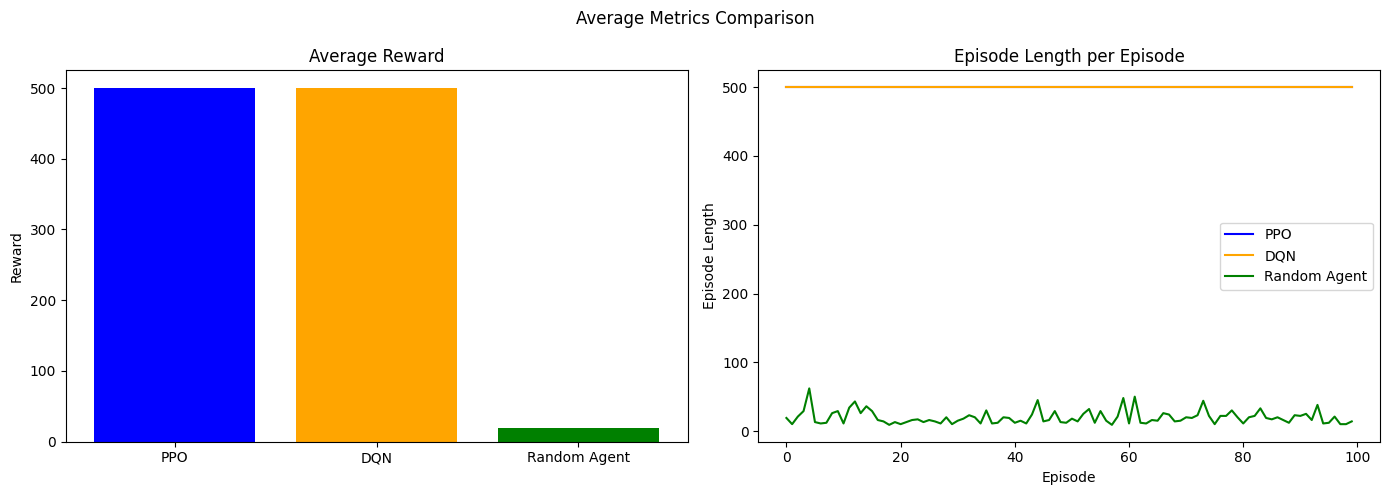

Average Rewards:
PPO: 500.00, DQN: 500.00, Random Agent: 19.94
Average Episode Lengths:
PPO: 500.00, DQN: 500.00, Random Agent: 19.94


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Run the simulation and collect metrics
num_episodes = 100
ppo_rewards, ppo_lengths = [], []
dqn_rewards, dqn_lengths = [], []
random_rewards, random_lengths = [], []

for _ in range(num_episodes):
    # PPO
    reward, length = run_episode(env, model=ppo_model)
    ppo_rewards.append(reward)
    ppo_lengths.append(length)

    # DQN
    reward, length = run_episode(env, model=dqn_model)
    dqn_rewards.append(reward)
    dqn_lengths.append(length)

    # Random Agent
    reward, length = run_episode(env, random_agent=True)
    random_rewards.append(reward)
    random_lengths.append(length)

# Plot Average Metrics Comparison
labels = ["PPO", "DQN", "Random Agent"]
average_rewards = [np.mean(ppo_rewards), np.mean(dqn_rewards), np.mean(random_rewards)]
average_lengths = [np.mean(ppo_lengths), np.mean(dqn_lengths), np.mean(random_lengths)]

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Average Rewards as Bar Chart
ax[0].bar(labels, average_rewards, color=['blue', 'orange', 'green'])
ax[0].set_title("Average Reward")
ax[0].set_ylabel("Reward")

# Episode Lengths per Episode
ax[1].plot(ppo_lengths, label="PPO", color='blue')
ax[1].plot(dqn_lengths, label="DQN", color='orange')
ax[1].plot(random_lengths, label="Random Agent", color='green')
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Episode Length")
ax[1].set_title("Episode Length per Episode")
ax[1].legend()

plt.suptitle("Average Metrics Comparison")
plt.tight_layout()
plt.show()

# Print average metrics
print("Average Rewards:")
print(f"PPO: {average_rewards[0]:.2f}, DQN: {average_rewards[1]:.2f}, Random Agent: {average_rewards[2]:.2f}")

print("Average Episode Lengths:")
print(f"PPO: {average_lengths[0]:.2f}, DQN: {average_lengths[1]:.2f}, Random Agent: {average_lengths[2]:.2f}")


Perfect score for both PPO and DQN. No comparison with the random agent.Average Rewards:
PPO: 500.00, DQN: 500.00, Random Agent: 19.94
Average Episode Lengths:
PPO: 500.00, DQN: 500.00, Random Agent: 19.94